Extended Kalman Filter

In [1]:
import numpy as np
from numpy import outer
from numpy import dot, zeros, eye
import scipy.linalg as linalg
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from numpy.random import normal
import scipy as scipy
import scipy.stats
from scipy.linalg import cholesky

In [2]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [3]:
#Simulates a range measurement
def ranges(dtime,xp,xv,yp):
    xv += np.random.randn()*.1
    yp += np.random.randn()*.1
    xp += xv*dtime
    range_error = xp *.05*np.random.randn()
    rangee = math.sqrt(xp**2 + yp**2)
    return [rangee + range_error,xp,xv,yp]


In [4]:
#initiate state 
xpinit, xvinit, ypinit,dt = 0,180,470,.1# velocity is constant at 200 , yp constant at 500, xp at 0

x0 = [xpinit,xvinit,ypinit]
transitionM = np.asarray([[1,dt,0],[0,1,0],[0,0,1]])
sigmarange = 4
R = np.diag([sigmarange**2])
Q = np.asarray([[2.5e-06, 5.0e-05,0],
       [5.0e-05, 1.0e-03,0],[0,0,.1]])
P =eye(3)*60
x0m = np.asarray(x0).reshape(3,1)

In [5]:
# recursive estimation
results = []
resultsP = []
results.append(x0m)
resultsP.append(P)
measurements = []
#generate measurements for filters
xinicial,xvinicial,yinicial = 0,200,500
for i in range(int(30/dt)):
    medidasguardar = ranges(dt,xinicial,xvinicial,yinicial)
    measurements.append(medidasguardar)
    xinicial,xvinicial,yinicial = medidasguardar[1],medidasguardar[2],medidasguardar[3]
    
    

In [6]:

for i in range(int(30/dt)):
    rangem = measurements[i][0]
   
    y =np.asarray([rangem])
    
    #H matrix
    
    
    hM = np.asarray([[x0m[0][0]/((x0m[0][0]**2 +x0m[2][0]**2)**.5),0,x0m[2][0]/((x0m[0][0]**2 +x0m[2][0]**2)**.5)]])
    #update
    k0 = np.dot(hM,np.dot(P,hM.T))+R
    k0i = linalg.inv(k0)
    #kalman gain
    Kalmang= np.dot(np.dot(P,hM.T),k0i)
    #innovation
    hx=(x0m[0][0]**2 +x0m[2][0]**2)**.5
 
    inno =y-hx
    
    inno = np.asarray([inno])
    #update state and covariance matrix
   
    
    x0m = x0m+np.dot(Kalmang,inno)
  
    results.append(x0m)
    IKH= eye(3)-np.dot(Kalmang,hM)
    P = np.dot(IKH,P)
    resultsP.append(P)
    #prediction
    x0m = np.dot(transitionM,x0m)
 
    P=np.dot(np.dot(transitionM,P),transitionM.T)+Q
resa = np.asarray(results)
resP = np.asarray(resultsP)
resM = np.asarray(measurements)

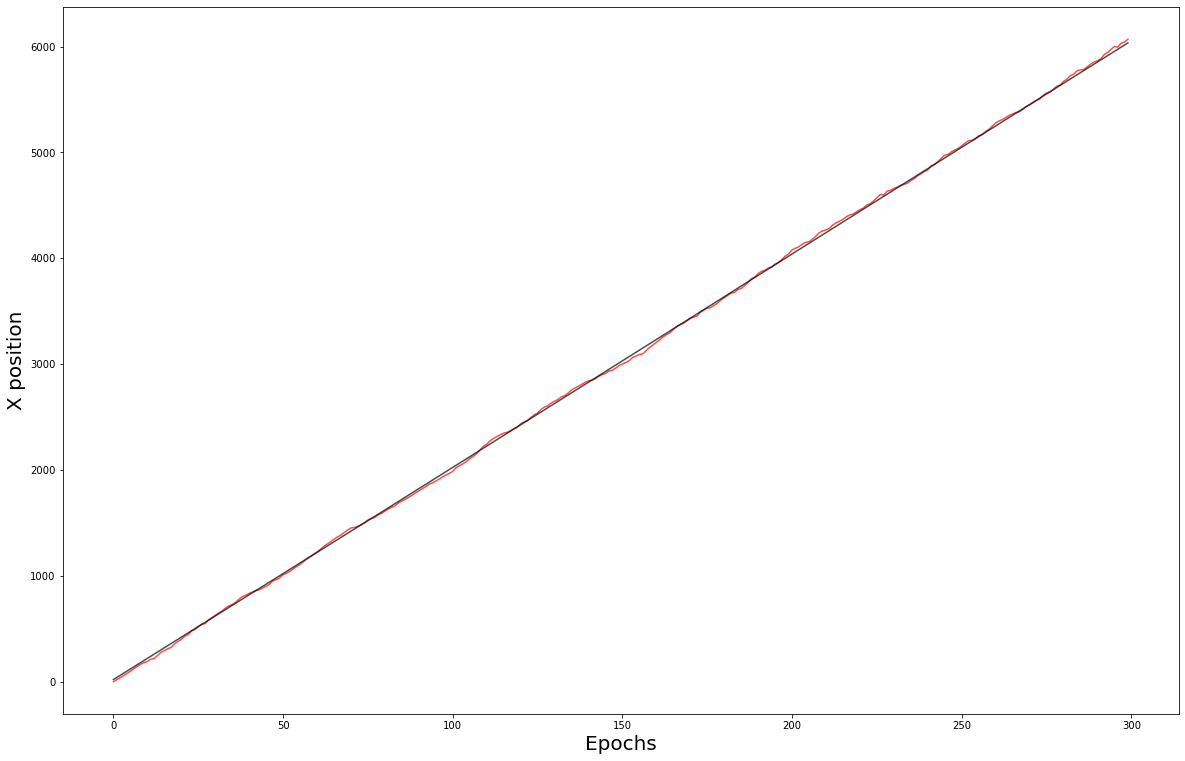

In [7]:
#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,0],c='r',alpha=.7)
ax.plot(tims,resM[:,1],c='black',alpha=.7)
#ax.set_title("L1 Carrier Phases",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'X position', fontsize = 20)
plt.show()

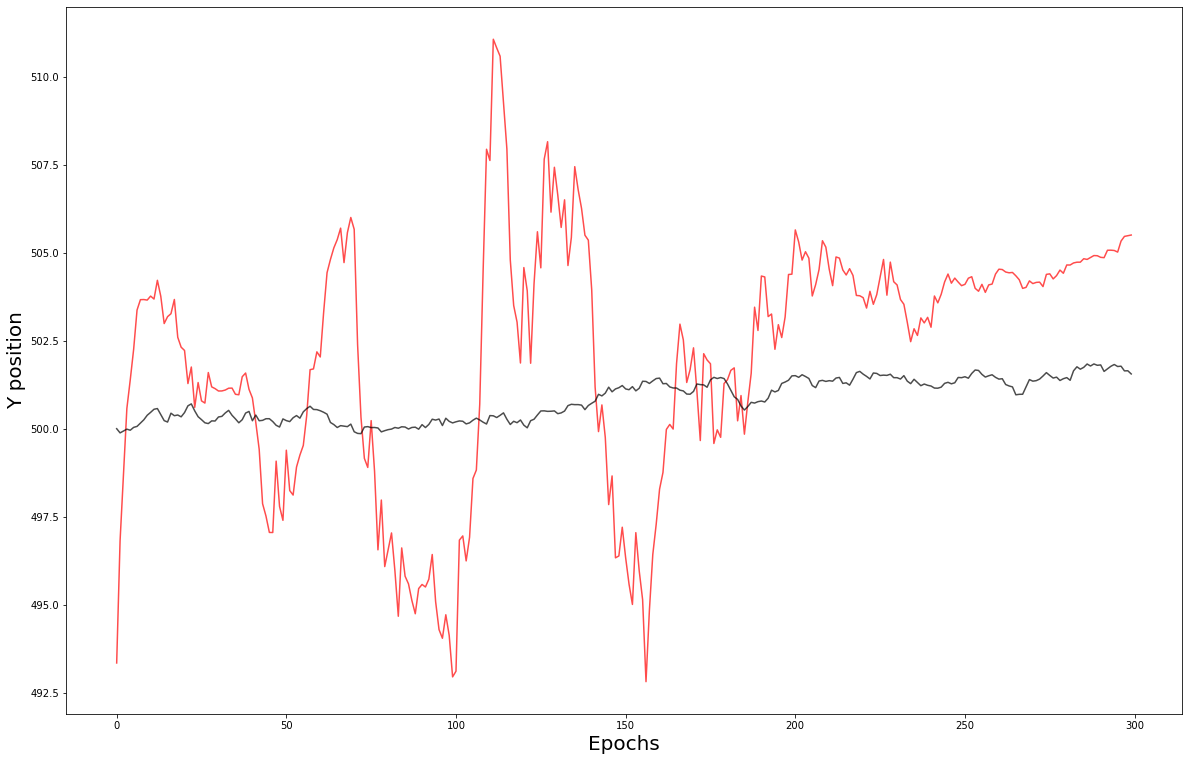

In [8]:
#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,2],c='r',alpha=.7)
ax.plot(tims,resM[:,3],c='black',alpha=.7)
#ax.set_title("L1 Carrier Phases",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Y position', fontsize = 20)
plt.show()

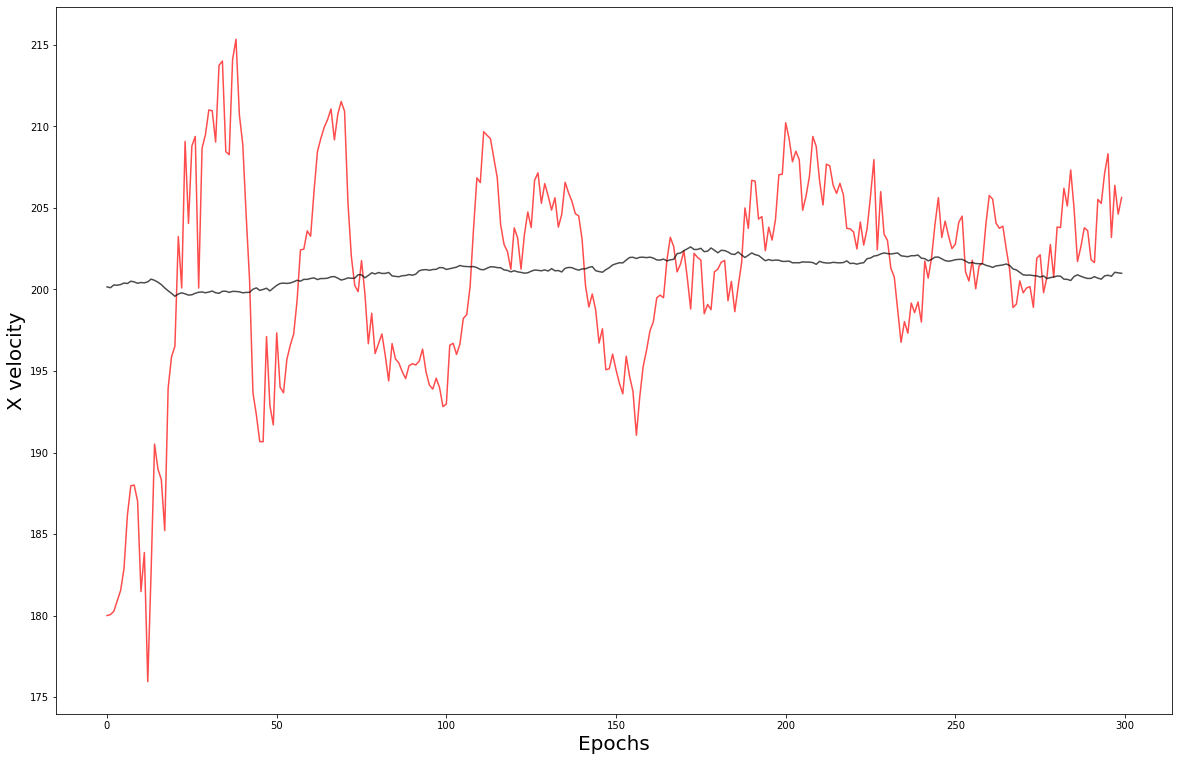

In [9]:
#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,1],c='r',alpha=.7)
ax.plot(tims,resM[:,2],c='black',alpha=.7)
#ax.set_title("L1 Carrier Phases",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'X velocity', fontsize = 20)
plt.show()

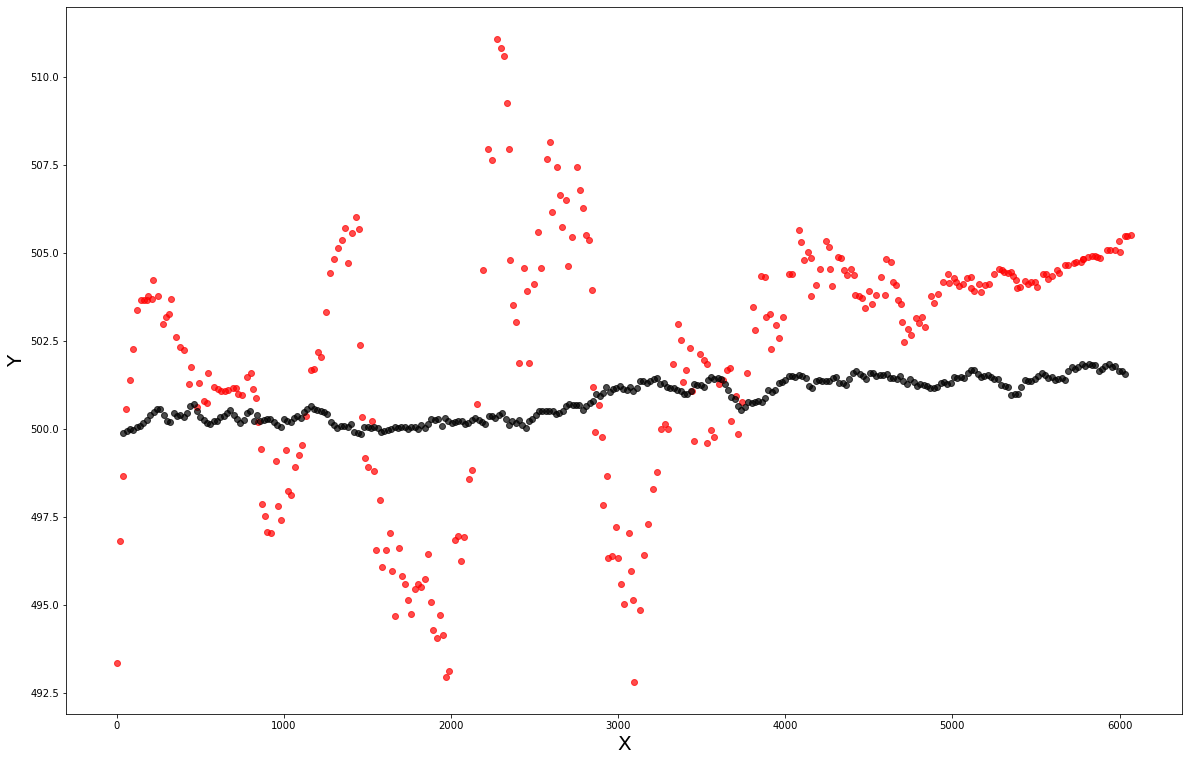

In [10]:
#Q(2, dt=0.1, var=.1, )
com =[]
for i in range(len(resP)):
    co = [[resP[i][0][0],resP[i][0][2]],[resP[i][2][0],resP[i][2][2]]]
    com.append(co)
com = np.asarray(com)
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.scatter(resa[1:,0],resa[1:,2],c='r',alpha=.7)
ax.scatter(resM[1:,1],resM[1:,3],c='black',alpha=.7)
scale = 1,1
'''for i in range(1,len(resP)):
        mu= resa[i,0][0],resa[i,2][0]
        #mu1=enu1[i,0],enu1[i,1]
        comat=com[i]
        #comat[0][0] = math.sqrt(comat[0][0])
        #comat[1][1] = math.sqrt(comat[1][1])
        #comat1=cov1[i][:2,:2]
        x, y = get_correlated_dataset(8000, comat, mu, scale)
        #x1, y1 = get_correlated_dataset(8000, comat1, mu1, scale1)
        #ax.scatter(x1, y1,c="red", marker = "+",alpha=.1)    
        confidence_ellipse(x, y, ax, edgecolor='red',n_std=2)
        '''
#ax.set_title("L1 Carrier Phases",fontsize=30)
plt.xlabel("X", fontsize = 20)
plt.ylabel(r'Y', fontsize = 20)
plt.show()

Particle Filter

In [11]:
def prediccionPF(arregloParticulas,deltat,std,flag):
    N = len(arregloParticulas)
    if (flag):
        
        arregloParticulas[:,2] += np.random.randn(N)*(abs(std[2]))
        arregloParticulas[:,1] += np.random.randn(N)*(abs(std[1]))
        #arregloParticulas[:,2] += np.random.randn(N)*abs(std[2])
        #arregloParticulas[:,1] += np.random.randn(N)*abs(std[1])
        #arregloParticulas[:,0] +=arregloParticulas[:,1]*deltat
        arregloParticulas[:,0] +=arregloParticulas[:,1]*deltat +np.random.randn(N)*(abs(std[0]))
    return arregloParticulas
        

In [12]:
def sampleGaussian(variances,valoresIniciales,numeroP,numStates):
    arregloParticulas = np.empty((numeroP,numStates))
    arregloParticulas[:,0] = normal(valoresIniciales[0],variances[0],size=numeroP)
    arregloParticulas[:,1] = normal(valoresIniciales[1],variances[1],size=numeroP)
    arregloParticulas[:,2] = normal(valoresIniciales[2],variances[2],size=numeroP)
    return arregloParticulas


In [13]:
def generateWeights(medidas,arregloParticulas,sigmaR):
    
    N = len(arregloParticulas)
   
    #generate weights equal for each Particle
    wlist = np.array([1.0]*N)
    distancias= []
    for i in range(N):
        dist = (arregloParticulas[i][0]**2+arregloParticulas[i][2]**2)**.5
        distancias.append(medidas-dist)
    distancias = np.asarray(distancias)
    wlist *= scipy.stats.norm(distancias[:],sigmaR).pdf(0)
    wlist += 1.e-300
    wlist /=sum(wlist)
    return wlist

In [14]:
def resample(nParticulas,weights):
    N = nParticulas

    positions = (np.arange(N)+ np.random.random())/N
    indexes = np.zeros(N,'i')
    cumulative_sum = np.cumsum(weights)
    f, j = 0, 0
    while f < N and j<N:
        if positions[f] < cumulative_sum[j]:
            indexes[f] = j
            f +=1
        else:
            j +=1
    #indices = deliver(indexes)
    return indexes

In [15]:
#initial values
xpinit, xvinit, ypinit,dt = 0,180,470,.1# velocity is constant at 200 , yp constant at 500, xp at 0
numerodeParticles = 35000
x0 = [xpinit,xvinit,ypinit]
resultsPF = []
resultsPFP = []
sigmarange = 16
P =eye(3)*60
numStates=3
f = True
Q = np.asarray([[2.5e-06, 5.0e-05,0],
       [5.0e-05, 1.0e-02,0],[0,0,.01]])
#Q = np.asarray([[2.5e-04, 5.0e-05,0],
 #      [5.0e-05, 1.0e-02,0],[0,0,1]])
#stdQ = [Q[0,0]**1,Q[1,1]**1,Q[2,2]**1]
stdQ = [Q[0,0]**.5,Q[1,1]**.5,Q[2,2]**.5]
#stdQ = [10,10,10]
particulas = sampleGaussian([P[0,0],P[1,1],P[2,2]],x0,numerodeParticles,numStates)
for i in range(int(30/dt)):
    medida = measurements[i][0]
    #weight particles
    pesos =generateWeights(medida,particulas,sigmarange)
    #update
    indices= resample(numerodeParticles,pesos)
    particulas[:]= particulas[indices]
    pesos= pesos[indices]
    pesos /= np.sum(pesos)
    #estimation
    est = np.average(particulas,weights = pesos, axis =0)
    sumatoria = 0
    for j in range(numerodeParticles):
        sumatoria += np.outer(particulas[j,:]-est, particulas[j,:]-est)
    Px = sumatoria /(numerodeParticles-1)
    resultsPF.append(est)
    resultsPFP.append(Px)
    #prediction
    particulas = prediccionPF(particulas,dt,stdQ,f)
resultsPFa = np.asarray(resultsPF)
resultsPFP = np.asarray(resultsPFP)

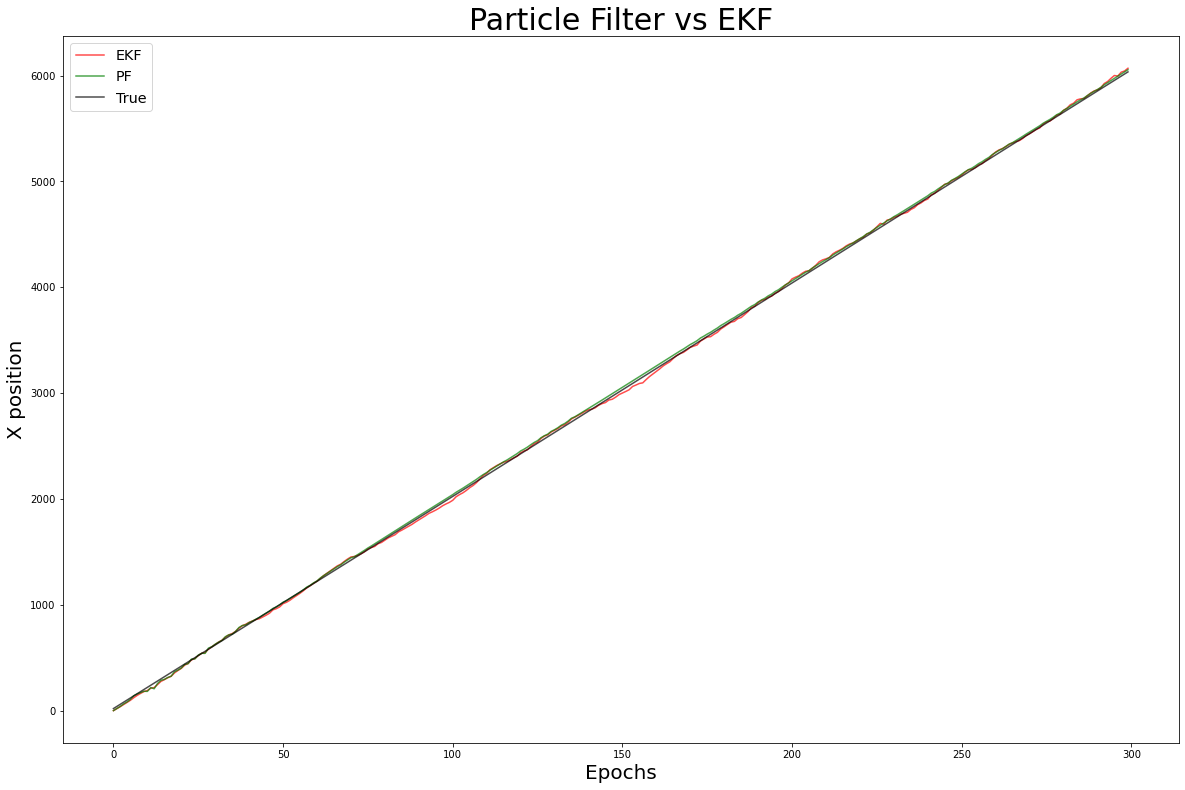

In [16]:
#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,resultsPFa[:,0],c='green',alpha=.7,label="PF")
ax.plot(tims,resM[:,1],c='black',alpha=.7,label="True")
ax.set_title("Particle Filter vs EKF",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'X position', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()

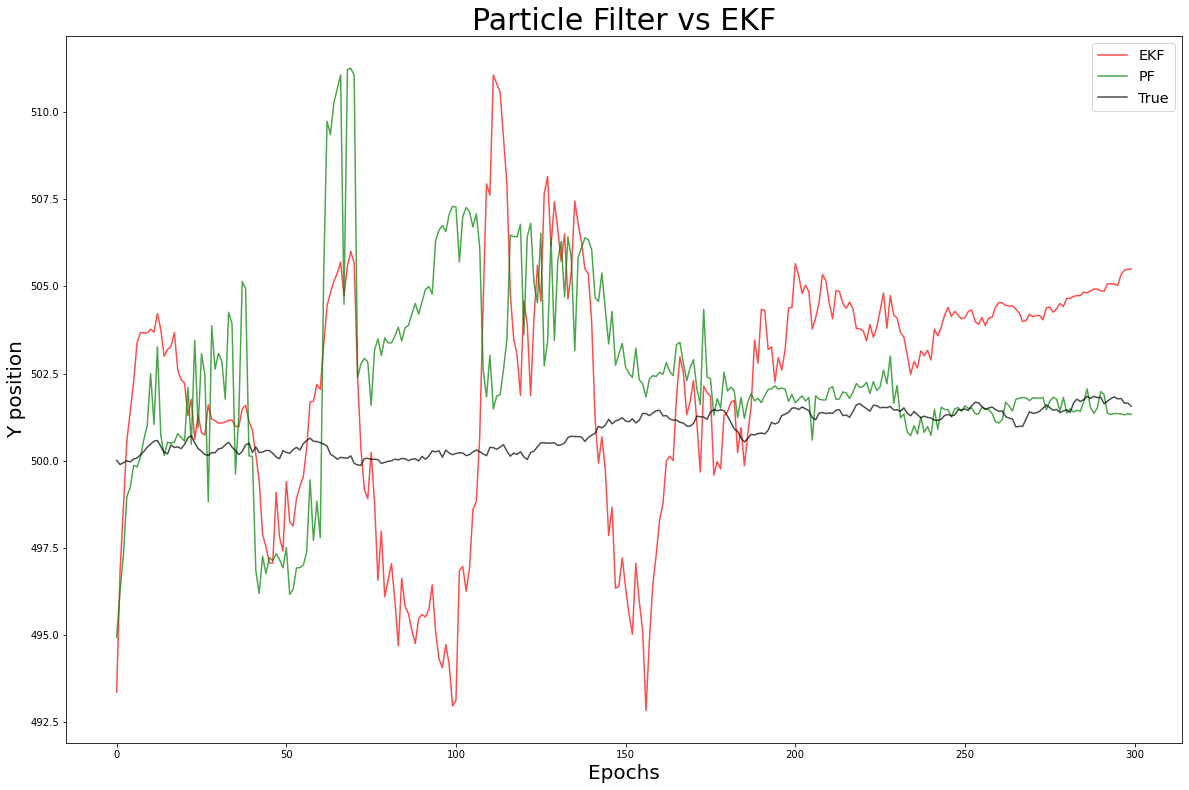

In [17]:


#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))

fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,2],c='red',alpha=.7,label="EKF")
ax.plot(tims,resultsPFa[:,2],c='green',alpha=.7,label="PF")
ax.plot(tims,resM[:,3],c='black',alpha=.7,label="True")
ax.set_title("Particle Filter vs EKF",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Y position', fontsize = 20)
ax.legend(loc=1,fontsize ='x-large')
plt.show()

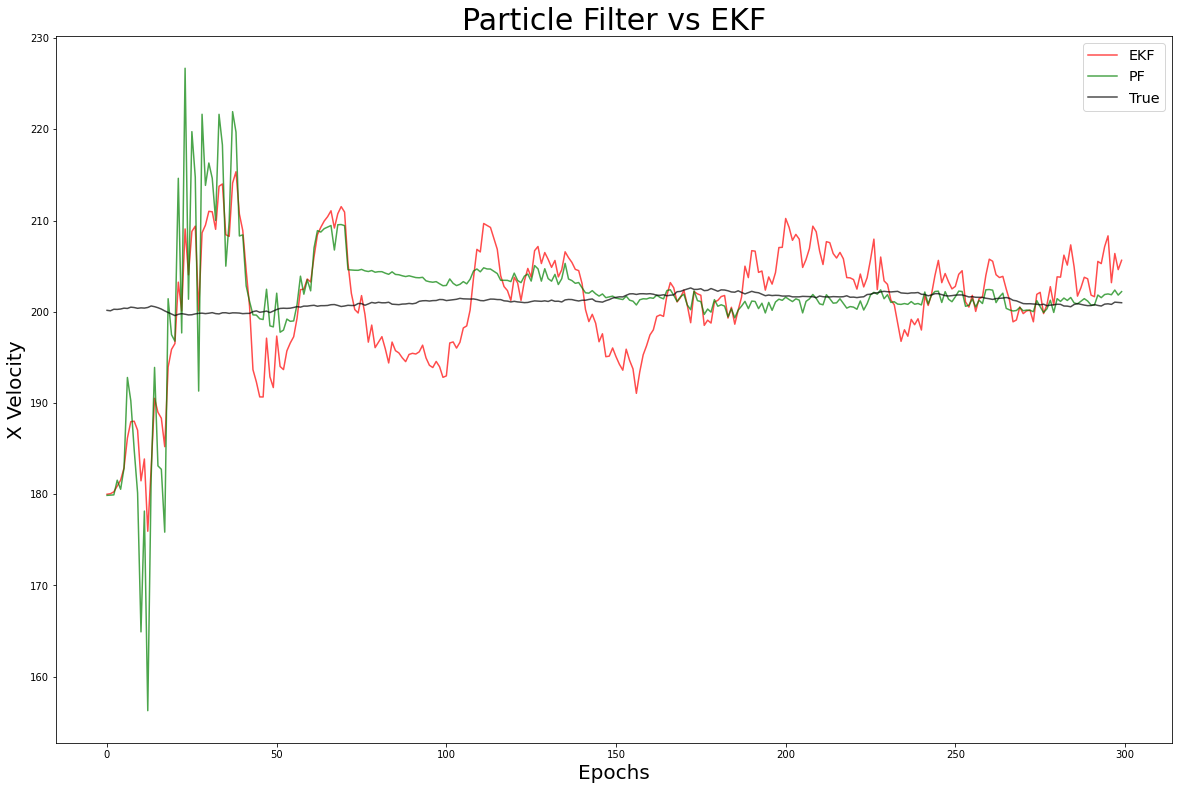

In [18]:
#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,1],c='red',alpha=.7,label="EKF")
ax.plot(tims,resultsPFa[:,1],c='green',alpha=.7,label="PF")
ax.plot(tims,resM[:,2],c='black',alpha=.7,label="True")
ax.set_title("Particle Filter vs EKF",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'X Velocity', fontsize = 20)
ax.legend(loc=1,fontsize ='x-large')
plt.show()

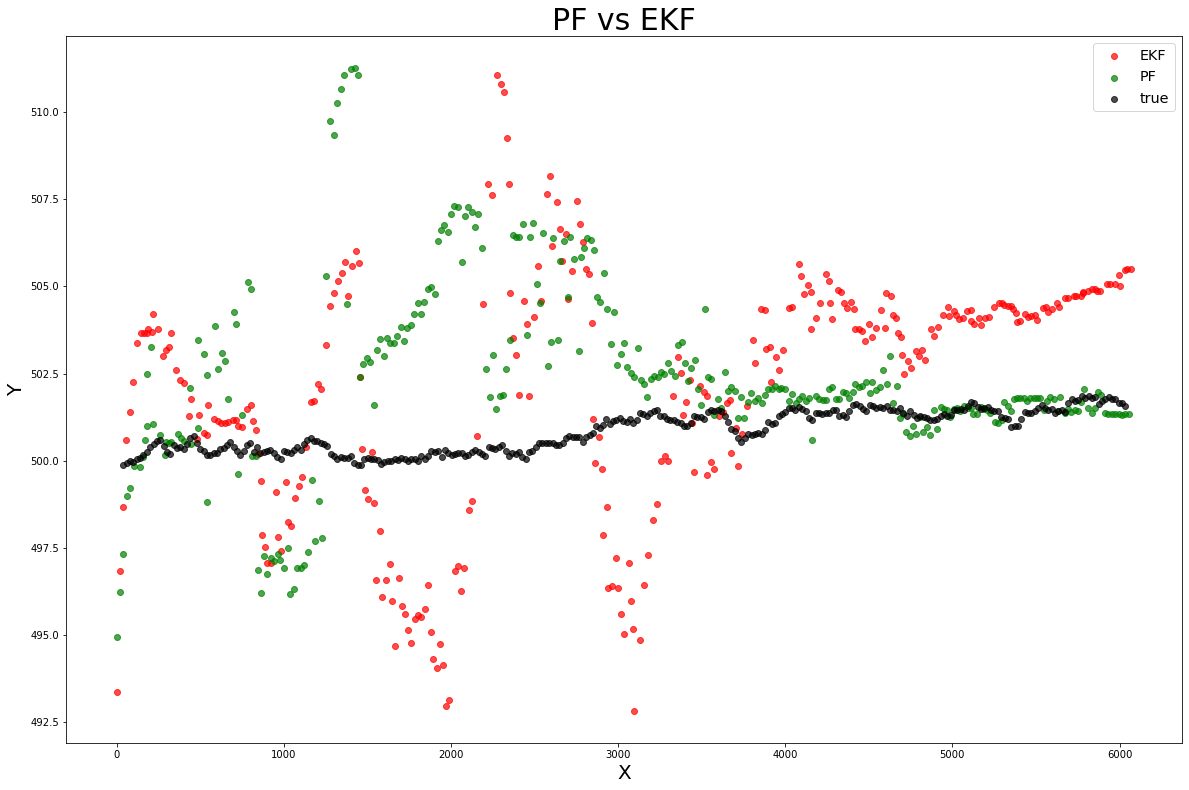

In [19]:
com =[]
for i in range(len(resP)):
    co = [[resP[i][0][0],resP[i][0][2]],[resP[i][2][0],resP[i][2][2]]]
    com.append(co)
com = np.asarray(com)
compf =[]
for i in range(len(resultsPFP)):
    co = [[resultsPFP[i][0][0],resultsPFP[i][0][2]],[resultsPFP[i][2][0],resultsPFP[i][2][2]]]
    compf.append(co)
compf = np.asarray(compf)
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.scatter(resa[1:,0],resa[1:,2],c='r',alpha=.7,label="EKF")
ax.scatter(resultsPFa[:,0],resultsPFa[:,2],c='green',alpha=.7,label="PF")
ax.scatter(resM[1:,1],resM[1:,3],c='black',alpha=.7,label="true")
scale = 1,1
'''for i in range(1,len(resP)):
        mu= resa[i,0][0],resa[i,2][0]
        #mu1=enu1[i,0],enu1[i,1]
        comat=com[i]
        #comat[0][0] = math.sqrt(comat[0][0])
        #comat[1][1] = math.sqrt(comat[1][1])
        #comat1=cov1[i][:2,:2]
        x, y = get_correlated_dataset(8000, comat, mu, scale)
        #x1, y1 = get_correlated_dataset(8000, comat1, mu1, scale1)
        #ax.scatter(x1, y1,c="red", marker = "+",alpha=.1)    
        confidence_ellipse(x, y, ax, edgecolor='red',n_std=2)
        
        '''
'''for i in range(0,len(resultsPFP)):
        mu= resultsPFa[i,0],resultsPFa[i,2]
        #mu1=enu1[i,0],enu1[i,1]
        comat=compf[i]
        #comat[0][0] = math.sqrt(comat[0][0])
        #comat[1][1] = math.sqrt(comat[1][1])
        #comat1=cov1[i][:2,:2]
        x, y = get_correlated_dataset(8000, comat, mu, scale)
        #x1, y1 = get_correlated_dataset(8000, comat1, mu1, scale1)
        #ax.scatter(x1, y1,c="red", marker = "+",alpha=.1)    
        confidence_ellipse(x, y, ax, edgecolor='green',n_std=1)'''
ax.set_title("PF vs EKF",fontsize=30)
plt.xlabel("X", fontsize = 20)
plt.ylabel(r'Y', fontsize = 20)
ax.legend(loc=1,fontsize ='x-large')
plt.show()

In [20]:
#Unscented Kalman Filter

In [21]:
diferenciaXPF=resM[:,1]-resultsPFa[:,0]
diferenciaXVPF =resM[:,2]-resultsPFa[:,1]
diferenciaYPF=resM[:,3]-resultsPFa[:,2]
diferenciaXEK = []
diferenciaXVEK = []
diferenciaYEK = []
for i in range(len(resM)):
    diferenciaXEK.append(resM[:,1][i]-resa[1:,0][i][0])
    diferenciaXVEK.append(resM[:,2][i]-resa[1:,1][i][0])
    diferenciaYEK.append(resM[:,3][i]-resa[1:,2][i][0])

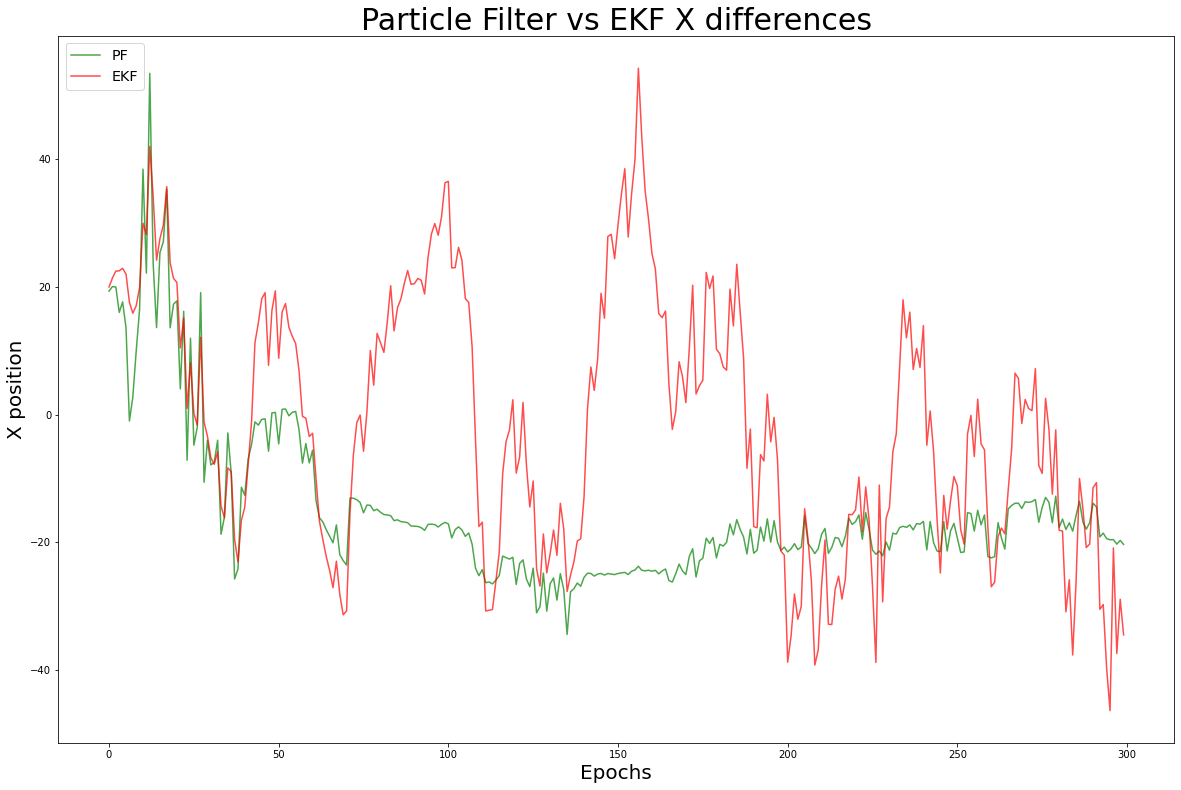

In [22]:
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
#ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaXPF[:],c='green',alpha=.7,label="PF")
ax.plot(tims,diferenciaXEK[:],c='red',alpha=.7,label="EKF")
ax.set_title("Particle Filter vs EKF X differences",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'X position', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()

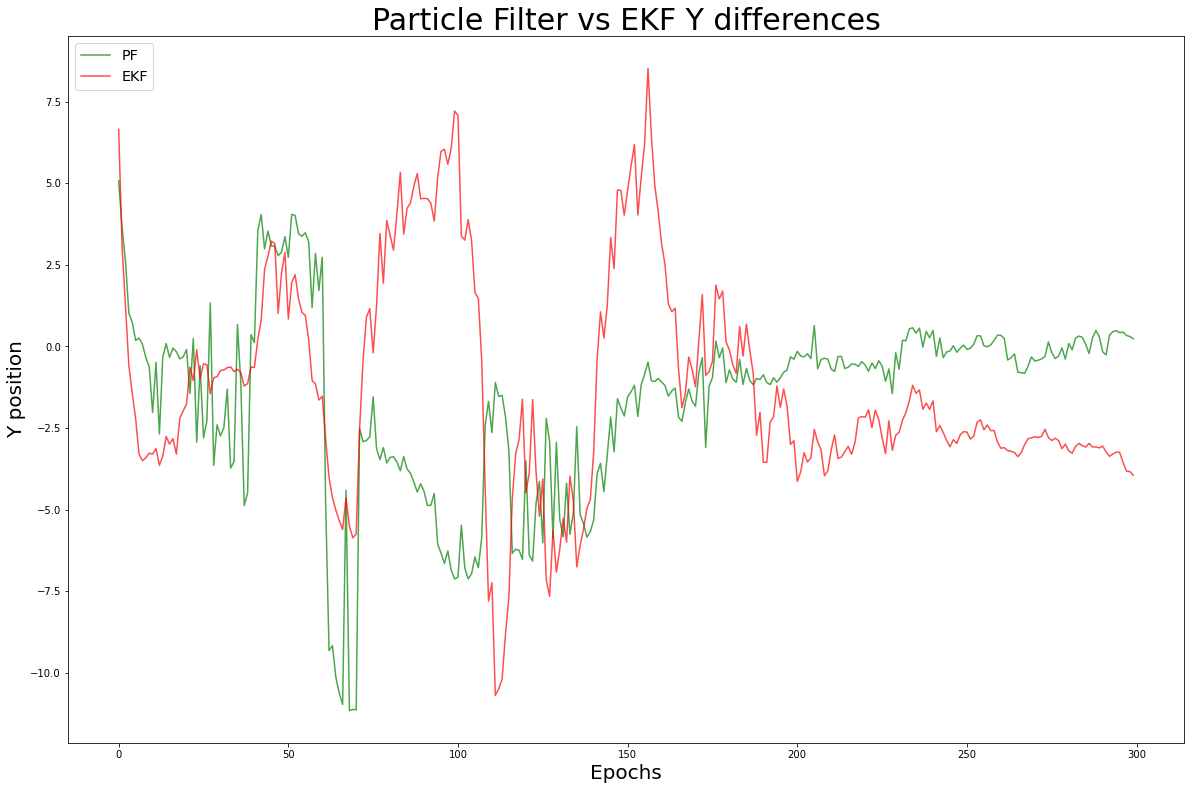

In [23]:
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
#ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaYPF[:],c='green',alpha=.7,label="PF")
ax.plot(tims,diferenciaYEK[:],c='red',alpha=.7,label="EKF")
ax.set_title("Particle Filter vs EKF Y differences",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Y position', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()

                         
    

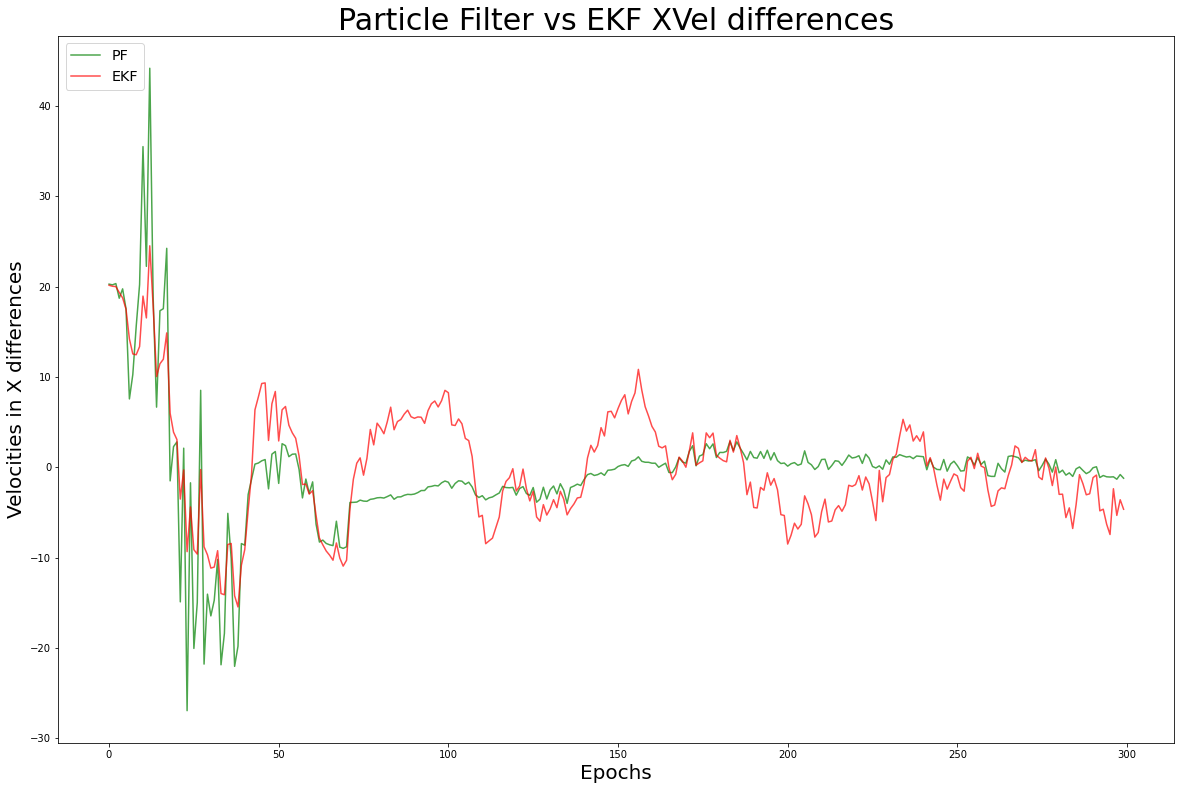

In [24]:
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
#ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaXVPF[:],c='green',alpha=.7,label="PF")
ax.plot(tims,diferenciaXVEK[:],c='red',alpha=.7,label="EKF")
ax.set_title("Particle Filter vs EKF XVel differences",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Velocities in X differences', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()


In [25]:
#Unscented Kalman Filter
numberStates =3
numberMeasurements =1 
alpha = .1 #alpha usually .1 (distance from the mean point)
kappa = 0 #usually 0
beta = 2
#results
resultsUKF = []
resultsUKFP = []
#initial values for x and P
P =eye(3)*60
sigmarange = 4
R = np.diag([sigmarange**2])
Q = np.asarray([[2.5e-06, 5.0e-05,0],
       [5.0e-05, 1.0e-03,0],[0,0,.1]])
xpinit, xvinit, ypinit,dt = 0,180,470,.1# velocity is constant at 200 , yp constant at 500, xp at 0
#transition matrix
transitionM = np.asarray([[1,dt,0],[0,1,0],[0,0,1]])
x0 = [xpinit,xvinit,ypinit]
x0m = np.asarray(x0)
numberSigmas = numberStates *2 +1 #number of points 2n +1
for i in range(int(30/dt)):
    rangem = measurements[i][0]
    Lam = alpha **2 * (numberStates + kappa)- numberStates #lambda
    # compute weights 
    cw = .5/ (numberStates + Lam)
    
    wcovariance = np.full(numberSigmas,cw)
    wcovariance[0]=Lam/(numberStates+Lam) + (1-alpha**2 +beta)
    
    wmean = np.full(numberSigmas,cw)
    wmean[0]=Lam/(numberStates+Lam)
    #Sigma Points 
    
    sigmaPointsx = np.zeros((numberSigmas,numberStates))
    sigmaPointsFx = np.zeros((numberSigmas,numberStates))
    sigmaPointsy = np.zeros((numberSigmas,numberMeasurements))
    
    root = cholesky((Lam +numberStates)*P)
    sigmaPointsx[0] = x0m
    
    
    for j in range(numberStates):
        dif1 = x0m + root[j]
        dif2 = x0m - root[j]
        sigmaPointsx[j+1] =dif1
        sigmaPointsx[numberStates+j+1]=dif2
    #pass sigma Points through transition matrix (f(x))
    #print ("x")
    #print (sigmaPointsx)
    for j in range(len(sigmaPointsx)):
        sigmaPointsFx[j] = np.dot(transitionM,sigmaPointsx[j])
    #prediction (compute prior mean and covariance with unscented transform)
    #compute new mean using sigmas and weights
    #print ("FX")
    #print (sigmaPointsFx)
    x0m = np.dot(wmean,sigmaPointsFx)
    #compute P using outer product empiric covariance matrix
    difP = sigmaPointsFx - x0m[np.newaxis,:]
    P = np.dot(difP.T,np.dot(np.diag(wcovariance),difP))
    #add noise
    P += Q
   
    #compute sigma for prior x and P 
    sigmaPointsx = np.zeros((numberSigmas,numberStates))
    Lam = alpha **2 * (numberStates + kappa)- numberStates #lambda
    root = cholesky((Lam +numberStates)*P)
    sigmaPointsx[0] = x0m
    for j in range(numberStates):
        dif1 = x0m + root[j]
        dif2 = x0m - root[j]
        sigmaPointsx[j+1] =dif1
        sigmaPointsx[numberStates+j+1]=dif2
    sigmaPointsFx = sigmaPointsx
    #copiar P y X en prior
    xantes = np.copy(x0m)
    Pantes = np.copy(P)
    
    #update step
    #transform sigma points into mearurements
    sigmahx = []#measurements
    for sp in sigmaPointsFx:
        sigmahx.append((sp[0]**2 +sp[2]**2)**.5)
    sigmaPointsy = np.atleast_2d(sigmahx)
    
    #pass sigmaPointsy through Unscented transform
 
    yp = np.dot(wmean,sigmaPointsy.T)
    difP = sigmaPointsy - yp[np.newaxis,:]
    #print (difP.T)
    Sy = np.dot(difP,np.dot(np.diag(wcovariance),difP.T))
    Sy+= R
    Syi = np.linalg.inv(Sy)
    #cross variance of measurements and state
 
    Pxy = np.zeros((sigmaPointsFx.shape[1],sigmaPointsy.T.shape[1]))
    numberSigmax = sigmaPointsFx.shape[0]
    for j in range(numberSigmax):
        dx = sigmaPointsFx[j] - x0m
        
        dy = sigmaPointsy.T[j]-yp
        Pxy += wcovariance[j] * outer(dx,dy)
    #kalman gain
    kalman = np.dot(Pxy,Syi)
    #innovation
    inno = rangem -yp
    #update with Kalman Gain
    x0m = np.add(x0m,np.dot(kalman,inno))
    P = P - np.dot(kalman,np.dot(Sy,kalman.T))
    resultsUKF.append(x0m)
    resultsUKFP.append(P)

    

In [26]:
resultsUKF = np.asarray(resultsUKF)
resulfsUKFP= np.asarray(resultsUKFP)

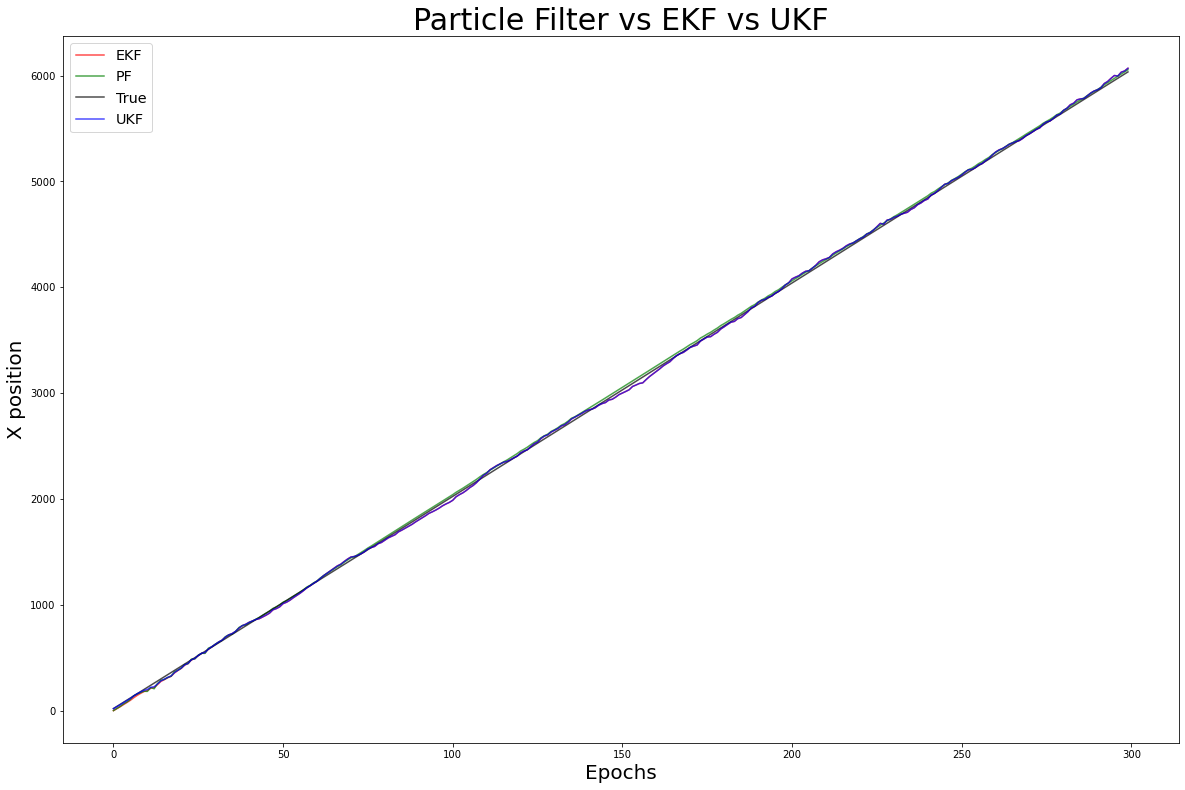

In [27]:
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,resultsPFa[:,0],c='green',alpha=.7,label="PF")
ax.plot(tims,resM[:,1],c='black',alpha=.7,label="True")
ax.plot(tims,resultsUKF[:,0],c='blue',alpha=.7,label="UKF")
ax.set_title("Particle Filter vs EKF vs UKF",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'X position', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()

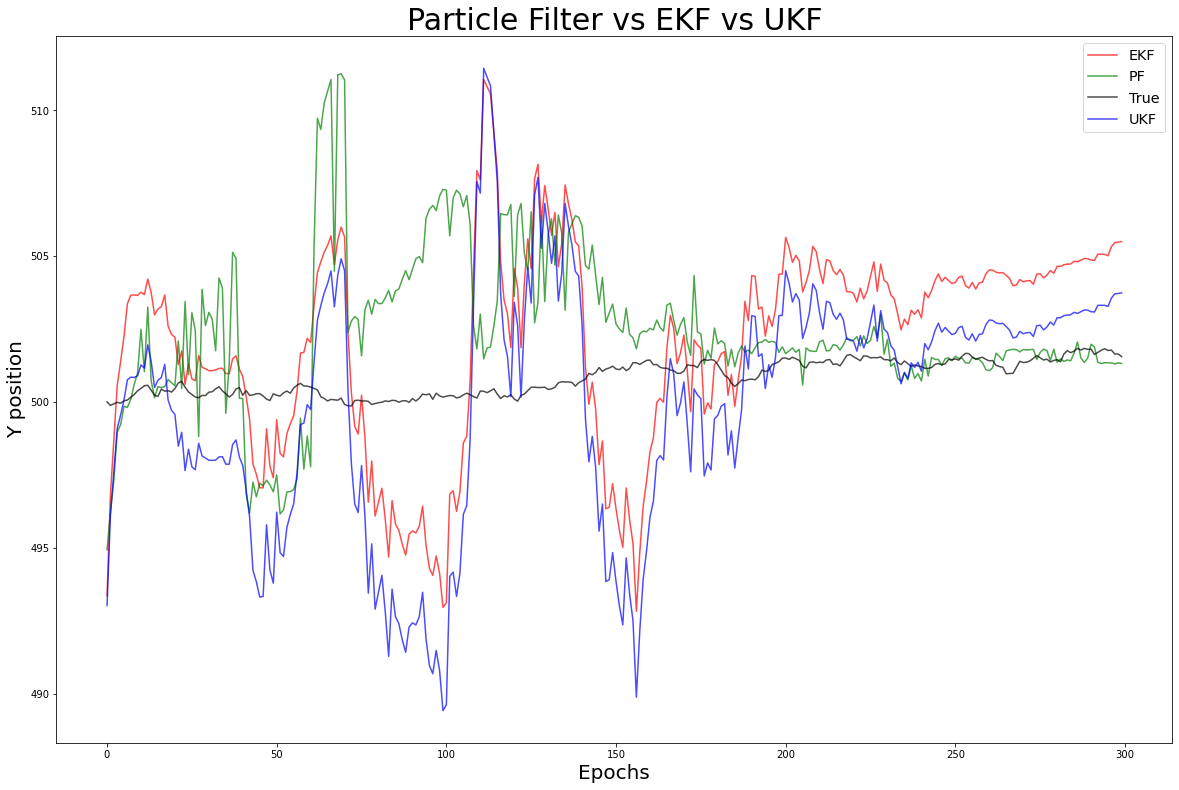

In [28]:
#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))

fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,2],c='red',alpha=.7,label="EKF")
ax.plot(tims,resultsPFa[:,2],c='green',alpha=.7,label="PF")
ax.plot(tims,resM[:,3],c='black',alpha=.7,label="True")
ax.plot(tims,resultsUKF[:,2],c='blue',alpha=.7,label="UKF")
ax.set_title("Particle Filter vs EKF vs UKF",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Y position', fontsize = 20)
ax.legend(loc=1,fontsize ='x-large')
plt.show()

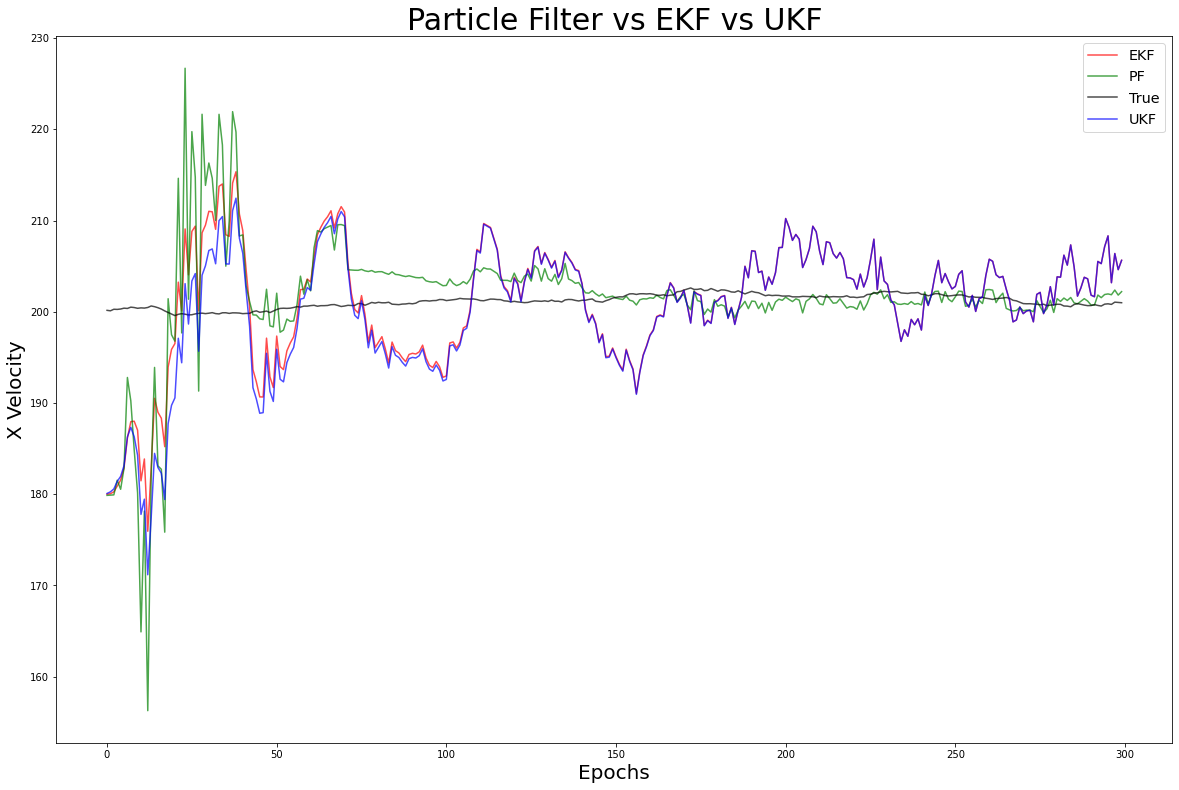

In [29]:
#Q(2, dt=0.1, var=.1, )
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(tims,resa[1:,1],c='red',alpha=.7,label="EKF")
ax.plot(tims,resultsPFa[:,1],c='green',alpha=.7,label="PF")
ax.plot(tims,resM[:,2],c='black',alpha=.7,label="True")
ax.plot(tims,resultsUKF[:,1],c='blue',alpha=.7,label="UKF")
ax.set_title("Particle Filter vs EKF vs UKF",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'X Velocity', fontsize = 20)
ax.legend(loc=1,fontsize ='x-large')
plt.show()

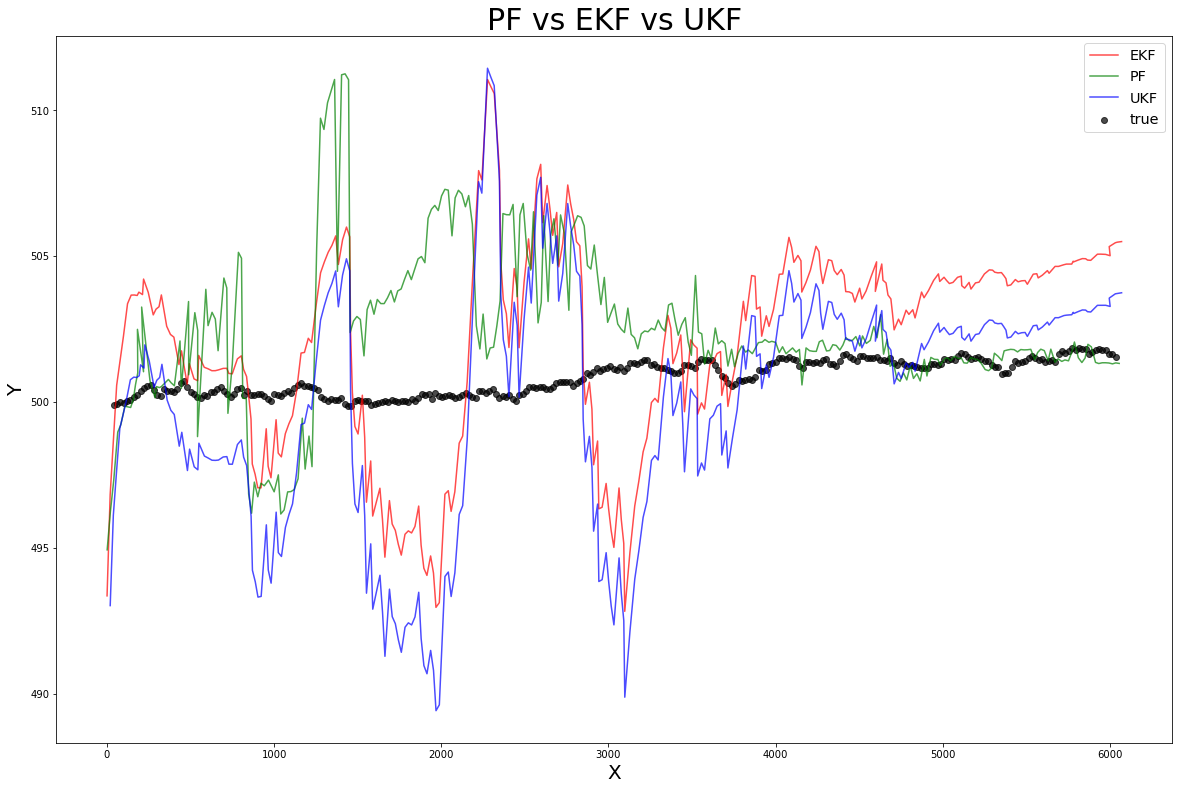

In [30]:
com =[]
for i in range(len(resP)):
    co = [[resP[i][0][0],resP[i][0][2]],[resP[i][2][0],resP[i][2][2]]]
    com.append(co)
com = np.asarray(com)
compf =[]
for i in range(len(resultsPFP)):
    co = [[resultsPFP[i][0][0],resultsPFP[i][0][2]],[resultsPFP[i][2][0],resultsPFP[i][2][2]]]
    compf.append(co)
compf = np.asarray(compf)
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.plot(resa[1:,0],resa[1:,2],c='r',alpha=.7,label="EKF")
ax.plot(resultsPFa[:,0],resultsPFa[:,2],c='green',alpha=.7,label="PF")
ax.plot(resultsUKF[:,0],resultsUKF[:,2],c='blue',alpha=.7,label="UKF")
ax.scatter(resM[1:,1],resM[1:,3],c='black',alpha=.7,label="true")
scale = 1,1
'''for i in range(1,len(resP)):
        mu= resa[i,0][0],resa[i,2][0]
        #mu1=enu1[i,0],enu1[i,1]
        comat=com[i]
        #comat[0][0] = math.sqrt(comat[0][0])
        #comat[1][1] = math.sqrt(comat[1][1])
        #comat1=cov1[i][:2,:2]
        x, y = get_correlated_dataset(8000, comat, mu, scale)
        #x1, y1 = get_correlated_dataset(8000, comat1, mu1, scale1)
        #ax.scatter(x1, y1,c="red", marker = "+",alpha=.1)    
        confidence_ellipse(x, y, ax, edgecolor='red',n_std=2)
        
        '''
'''for i in range(0,len(resultsPFP)):
        mu= resultsPFa[i,0],resultsPFa[i,2]
        #mu1=enu1[i,0],enu1[i,1]
        comat=compf[i]
        #comat[0][0] = math.sqrt(comat[0][0])
        #comat[1][1] = math.sqrt(comat[1][1])
        #comat1=cov1[i][:2,:2]
        x, y = get_correlated_dataset(8000, comat, mu, scale)
        #x1, y1 = get_correlated_dataset(8000, comat1, mu1, scale1)
        #ax.scatter(x1, y1,c="red", marker = "+",alpha=.1)    
        confidence_ellipse(x, y, ax, edgecolor='green',n_std=1)'''
ax.set_title("PF vs EKF vs UKF",fontsize=30)
plt.xlabel("X", fontsize = 20)
plt.ylabel(r'Y', fontsize = 20)
ax.legend(loc=1,fontsize ='x-large')
plt.show()

In [31]:
diferenciaXPF=resM[:,1]-resultsPFa[:,0]
diferenciaXVPF =resM[:,2]-resultsPFa[:,1]
diferenciaYPF=resM[:,3]-resultsPFa[:,2]
diferenciaXUK=resM[:,1]-resultsUKF[:,0]
diferenciaXVUK =resM[:,2]-resultsUKF[:,1]
diferenciaYUK=resM[:,3]-resultsUKF[:,2]

diferenciaXEK = []
diferenciaXVEK = []
diferenciaYEK = []
for i in range(len(resM)):
    diferenciaXEK.append(resM[:,1][i]-resa[1:,0][i][0])
    diferenciaXVEK.append(resM[:,2][i]-resa[1:,1][i][0])
    diferenciaYEK.append(resM[:,3][i]-resa[1:,2][i][0])

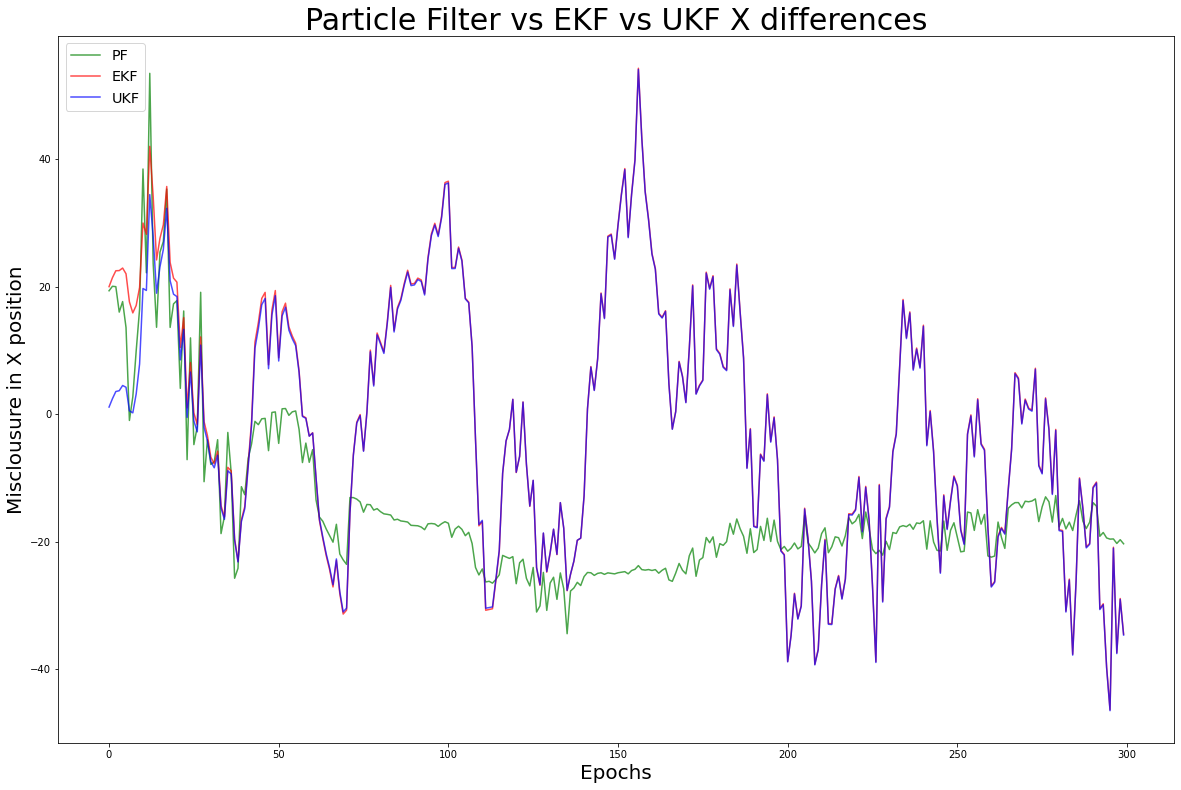

In [32]:
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
#ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaXPF[:],c='green',alpha=.7,label="PF")
ax.plot(tims,diferenciaXEK[:],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaXUK[:],c='blue',alpha=.7,label="UKF")
ax.set_title("Particle Filter vs EKF vs UKF X differences",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Misclousure in X position', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()

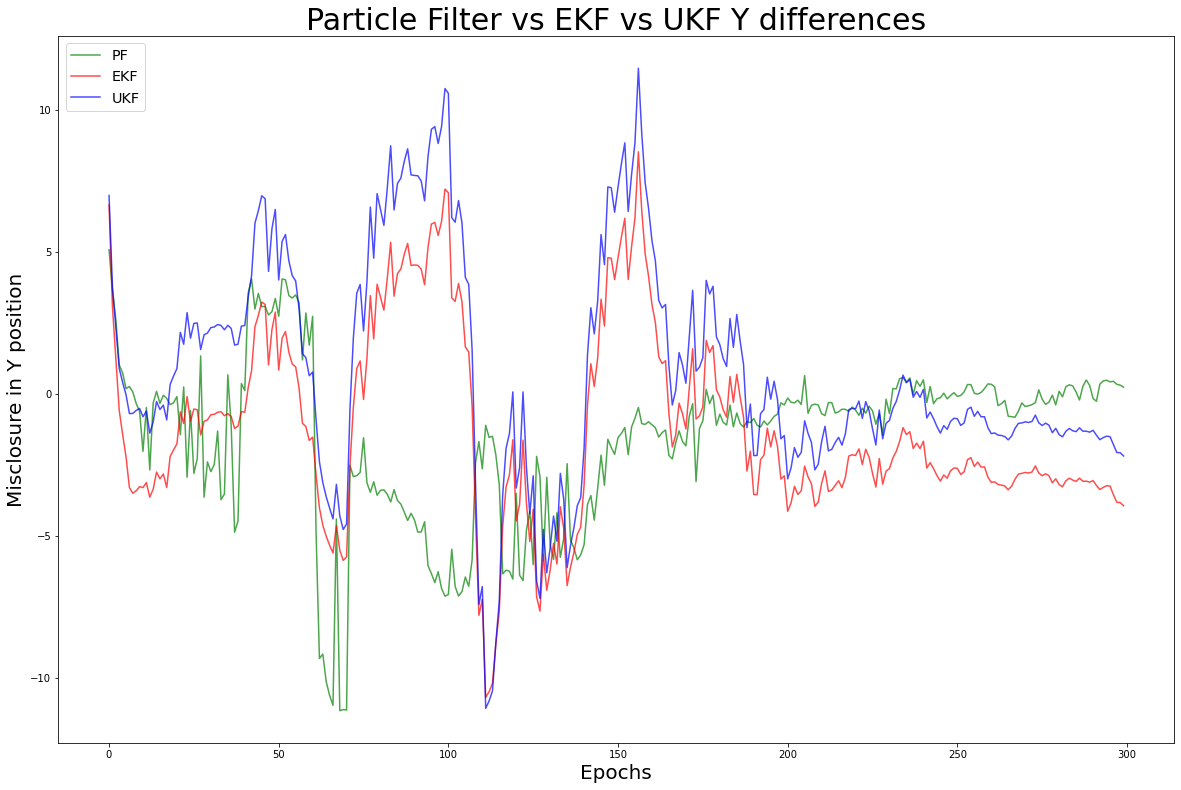

In [33]:
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
#ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaYPF[:],c='green',alpha=.7,label="PF")
ax.plot(tims,diferenciaYEK[:],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaYUK[:],c='blue',alpha=.7,label="UKF")
ax.set_title("Particle Filter vs EKF vs UKF Y differences",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Misclosure in Y position', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()

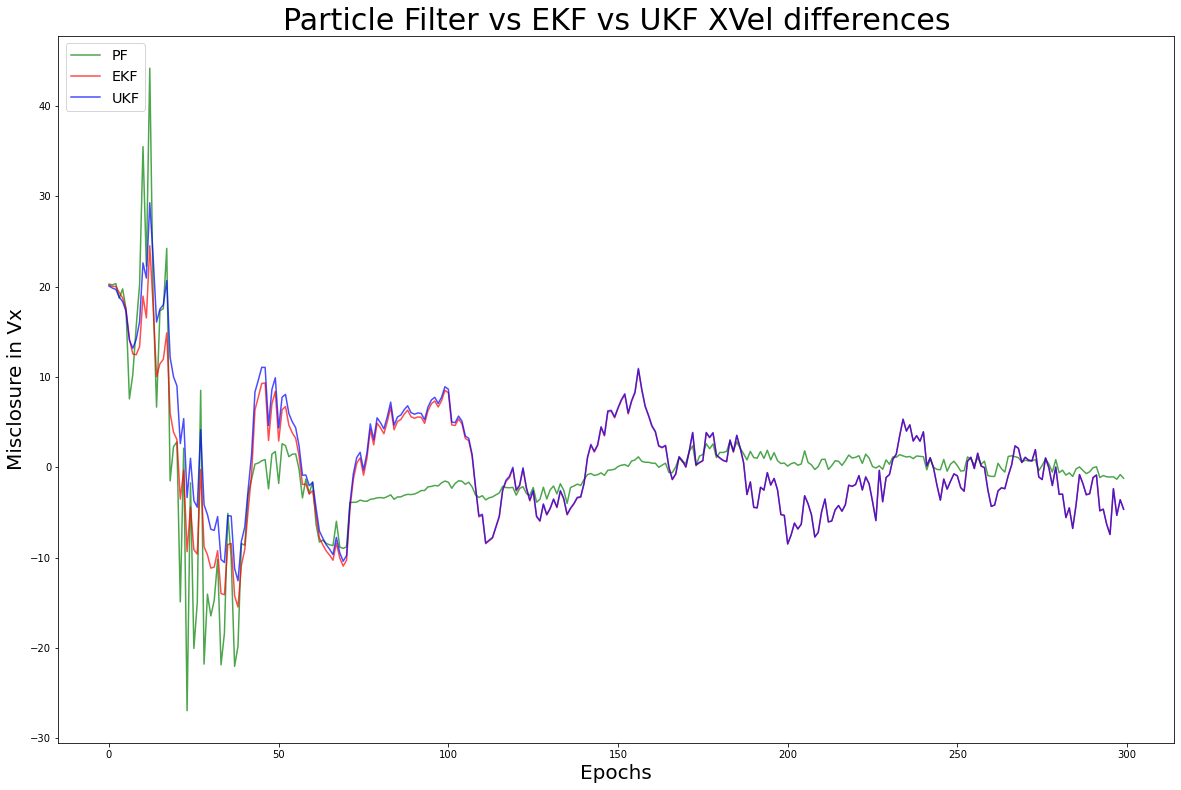

In [34]:
tims = np.arange(0,len(resM))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
#ax.plot(tims,resa[1:,0],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaXVPF[:],c='green',alpha=.7,label="PF")
ax.plot(tims,diferenciaXVEK[:],c='red',alpha=.7,label="EKF")
ax.plot(tims,diferenciaXVUK[:],c='blue',alpha=.7,label="UKF")
ax.set_title("Particle Filter vs EKF vs UKF XVel differences",fontsize=30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel(r'Misclosure in Vx', fontsize = 20)
ax.legend(loc=2,fontsize ='x-large')
plt.show()
